# <span style="color:green"> Numerical Simulation Laboratory </span>
## <span style="color:brown"> Python Exercise 11 </span>
## <span style="color:orange"> Keras - Neural Network regression </span>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import math
from scipy.optimize import curve_fit
plt.rcParams.update({
    'font.family':'cmr10',
    'mathtext.fontset': 'cm',
    'axes.formatter.use_mathtext': True,
    'axes.axisbelow': True,
    'figure.figsize': [6.0, 6.0],
    'axes.labelsize': 15,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15,
    'font.size':15,
})

# compose the NN model
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

### Overview 

In this notebook our task will be to perform machine learning regression on noisy data with a Neural Network (NN).

We will explore how the ability to fit depends on the structure of the NN. The goal is also to build intuition about why prediction is difficult.

### The Prediction Problem

Consider a probabilistic process that gives rise to labeled data $(x,y)$. The data is generated by drawing samples from the equation

$$
    y_i= f(x_i) + \eta_i,
$$

where $f(x_i)$ is some fixed, but (possibly unknown) function, and $\eta_i$ is a Gaussian, uncorrelate noise variable such that

$$
\langle \eta_i \rangle=0 \\
\langle \eta_i \eta_j \rangle = \delta_{ij} \sigma
$$

We will refer to the $f(x_i)$ as the **true features** used to generate the data. 

To make predictions, we will consider a NN that depends on its parameters, weights and biases. The functions that the NN can model respresent the **model class** that we are using to try to model the data and make predictions.

To learn the parameters of the NN, we will train our models on a **training data set** and then test the effectiveness of the NN on a *different* dataset, the **validation data set**. The reason we must divide our data into a training and test dataset is that the point of machine learning is to make accurate predictions about new data we have not seen.

To measure our ability to predict, we will learn our parameters by fitting our training dataset and then making predictions on our test data set. One common measure of predictive  performance of our algorithm is to compare the predictions,$\{y_j^\mathrm{pred}\}$, to the true values $\{y_j\}$. A commonly employed measure for this is the sum of the mean square-error (MSE) on the test set:
$$
MSE= \frac{1}{N_\mathrm{test}}\sum_{j=1}^{N_\mathrm{test}} (y_j^\mathrm{pred}-y_j)^2
$$

We will try to get a qualitative picture by examining plots on validation and training data.

### Exercise 11.1

In order to make practice with NN, explore how does the previous linear regression depend on the number of epochs, $N_{\mathrm{epochs}}$, the number of data points $N_{\mathrm{train}}$ and on the noise $\sigma$. Try to improve the previous result operating on these parameters.

### Linear fit

Consideriamo la funzione lineare:
$$
f(x)=2x+1
$$

In [3]:
N_train = [300, 500, 1000, 1500]
N_epochs = [10, 30, 50, 100]
sigma = [0.05, 0.1, 0.2, 0.25]

Definiamo le seguenti funzioni:
- __initialize_traing__ : genera le coppie di dati input che hanno un certo errore $(\sigma)$ rispetto al comportamento ideale della retta
- __initialize_validation__ : gerera le coppie di dati per la valdazione del modello
- __neurons__ : inizializza il modello con con certo numero $(n_{neurons})$ di neuroni
- __history__ : gli diamo in input le coppie di training $(x_{train}, y_{train})$ da cui l'ottimizzatore troverà i pesi migliori per minimizzare la funzione costo (_Mean Square Error_).


Definiamo la funzione ``` training_validation ``` che ha come input il numero di dati per allenare il modello $(N_{train})$, il numero di layer della rete $(N_{layer})$, il numero di epoche $(N_{epochs})$, il sigma $(\sigma)$ e i parametri della funzione polinomiale che si sta predicendo.

In questa funzione vengono definiti i punti (coppie $x, y$) che vengono utilizzati per allenare il modello, le $x$ usate per validare il modello da cui si valutano le $y_{target} che serviranno a confrontare i risultati predetti con quelli reali per studiare l'efficiacia del modello.

Le coppie di training vengono create generando casualmente valori di x e valutando y come la fuznone che si sta valutando con un certo bias dato dal valore di sigma.

Viene poi definito il modello che è composto da $N_{layers}$ layer, ciascuno con la sua funzione di attivazione e con un certo numero di neuroni. Viene poi allenato il modello con le coppie $(x,y)_{train}$ e validato con le x generate prima.
La funzione restituisce i vslori di validazione, il modello e i valori dell'accuratezza e della loss function ottenuti dal modello. Questi ultimi due parametri ci permetteranno di verificare come varia l'efficienza del modello, infatti graficando il loro andamento al crescere del nuemro di epoche ci aspettiamo che la loss descresca e l'accuratezza aumenti, infatti più epoche vengono utilizzate più il modello viene allenato e quindi sarà in grado di predirre i valori richiesti con più precisione.
Questo sarà proprio quello che otterremo dopo graficando questi paramtri al variare del nuemro di epoche.

In [4]:
def training_validation(n_train, n_layer, n_epoch, sigma, a, b, c, d):
    # generate training inputs
    np.random.seed(0)
    x_train = np.random.uniform(-1, 1, n_train)
    sigma = 0.1 # noise standard deviation, for the moment it is absent
    y_train = np.random.normal(d + c* x_train +b * x_train**2 + a * x_train**3, sigma) # actual measures from which we want to guess regression parameters
    x_valid = np.random.uniform(-1, 1, 50)
    x_valid.sort()
    y_target = d + c* x_valid +b * x_valid**2 + a * x_valid**3  # ideal (target) linear function

    y_valid = np.random.normal(d + c* x_valid +b * x_valid**2 + a * x_valid**3, sigma)
    model = tf.keras.Sequential()
    if(n_layer > 1):
        model.add(Dense(4, input_shape=(1,), activation='relu'))
        model.add(Dense(16, input_shape=(1,), activation='relu'))
        model.add(Dense(16, input_shape=(1,), activation='relu'))
        model.add(Dense(4, input_shape=(1,), activation='relu'))
    model.add(Dense(1, input_shape=(1,)))
    # compile the model choosing optimizer, loss and metrics objects
    model.compile(optimizer='sgd', loss='mse', metrics=['mse'])
    # get a summary of our composed model
    model.summary()
    model.get_weights()
    history = model.fit(x=x_train, y=y_train, 
              batch_size=32, epochs=n_epoch,
              shuffle=True, # a good idea is to shuffle input before at each epoch
              validation_data=(x_valid, y_valid))
    score = model.evaluate(x_valid, y_valid, batch_size=32, verbose=1)
    return x_valid, y_target, model, history.history['loss'], history.history['val_loss']


In questo caso abbiamo solo due parametri da trovare $(m,b)$ quindi ci basta un solo neurone.

Guardando i pesi possiamo vedere se il modello è stato allenanto bene: $w_1$ rappresenta il coefficiente angolare della retta e $b$ l'intercetta. Quindi in questo caso ci aspettiamo: $w_1=2$ e $b=1$

/home/catezac/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-06-22 15:50:06.972058: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 4.5922 - mse: 4.5922 - val_loss: 3.8217 - val_mse: 3.8217
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.9117 - mse: 2.9117 - val_loss: 2.4123 - val_mse: 2.4123
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8308 - mse: 1.8308 - val_loss: 1.5792 - val_mse: 1.5792
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0781 - mse: 1.0781 - val_loss: 1.0713 - val_mse: 1.0713
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7373 - mse: 0.7373 - val_loss: 0.7503 - val_mse: 0.7503
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5525 - mse: 0.5525 - val_loss: 0.5437 - val_mse: 0.5437
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3901 - mse: 0.3901 - val_loss: 0.4029 - val_mse: 0.4029
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3099 - mse: 0.3099 - val_loss: 0.3077 - val_mse: 0.3077
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2304 - mse:

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_1 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5506 - mse: 3.5506 - val_loss: 2.7064 - val_mse: 2.7064
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9295 - mse: 1.9295 - val_loss: 1.5466 - val_mse: 1.5466
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0663 - mse: 1.0663 - val_loss: 0.9085 - val_mse: 0.9085
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6470 - mse: 0.6470 - val_loss: 0.5553 - val_mse: 0.5553
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3572 - mse: 0.3572 - val_loss: 0.3504 - val_mse: 0.3504
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2376 - mse: 0.2376 - val_loss: 0.2297 - val_mse: 0.2297
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1425 - mse: 0.1425 - val_loss: 0.1577 - val_mse: 0.1577
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0942 - mse: 0.0942 - val_loss: 0.1124 - val_mse: 0.1124
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0762 - mse:

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1612 - mse: 5.1612 - val_loss: 4.3156 - val_mse: 4.3156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.1901 - mse: 3.1901 - val_loss: 2.7807 - val_mse: 2.7807
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9494 - mse: 1.9494 - val_loss: 1.8548 - val_mse: 1.8548
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.2811 - mse: 1.2811 - val_loss: 1.2855 - val_mse: 1.2855
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9044 - mse: 0.9044 - val_loss: 0.9211 - val_mse: 0.9211
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7099 - mse: 0.7099 - val_loss: 0.6822 - val_mse: 0.6822
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5148 - mse: 0.5148 - val_loss: 0.5132 - val_mse: 0.5132
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3960 - mse: 0.3960 - val_loss: 0.3950 - val_mse: 0.3950
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3210 - mse:

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.4976 - mse: 3.4976 - val_loss: 2.1125 - val_mse: 2.1125
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9042 - mse: 1.9042 - val_loss: 1.1374 - val_mse: 1.1374
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0048 - mse: 1.0048 - val_loss: 0.6250 - val_mse: 0.6250
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5641 - mse: 0.5641 - val_loss: 0.3545 - val_mse: 0.3545
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3248 - mse: 0.3248 - val_loss: 0.2079 - val_mse: 0.2079
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1852 - mse: 0.1852 - val_loss: 0.1280 - val_mse: 0.1280
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1217 - mse: 0.1217 - val_loss: 0.0838 - val_mse: 0.0838
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0704 - mse: 0.0704 - val_loss: 0.0579 - val_mse: 0.0579
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0514 - mse:

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.4594 - mse: 3.4594 - val_loss: 2.2991 - val_mse: 2.2991
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8097 - mse: 1.8097 - val_loss: 1.2496 - val_mse: 1.2496
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9501 - mse: 0.9501 - val_loss: 0.6903 - val_mse: 0.6903
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5152 - mse: 0.5152 - val_loss: 0.3882 - val_mse: 0.3882
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2780 - mse: 0.2780 - val_loss: 0.2244 - val_mse: 0.2244
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1565 - mse: 0.1565 - val_loss: 0.1345 - val_mse: 0.1345
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0856 - mse: 0.0856 - val_loss: 0.0841 - val_mse: 0.0841
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0558 - val_mse: 0.0558
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0309 - mse:

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.7911 - mse: 3.7911 - val_loss: 2.8091 - val_mse: 2.8091
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.0156 - mse: 2.0156 - val_loss: 1.6266 - val_mse: 1.6266
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1607 - mse: 1.1607 - val_loss: 0.9708 - val_mse: 0.9708
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7040 - mse: 0.7040 - val_loss: 0.6001 - val_mse: 0.6001
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3827 - mse: 0.3827 - val_loss: 0.3861 - val_mse: 0.3861
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2421 - mse: 0.2421 - val_loss: 0.2571 - val_mse: 0.2571
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1635 - mse: 0.1635 - val_loss: 0.1789 - val_mse: 0.1789
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1168 - mse: 0.1168 - val_loss: 0.1292 - val_mse: 0.1292
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0928 - mse:

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.2405 - mse: 4.2405 - val_loss: 3.6325 - val_mse: 3.6325
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5411 - mse: 2.5411 - val_loss: 2.2529 - val_mse: 2.2529
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.5637 - mse: 1.5637 - val_loss: 1.4524 - val_mse: 1.4524
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9460 - mse: 0.9460 - val_loss: 0.9705 - val_mse: 0.9705
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7225 - mse: 0.7225 - val_loss: 0.6729 - val_mse: 0.6729
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4773 - mse: 0.4773 - val_loss: 0.4827 - val_mse: 0.4827
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3409 - mse: 0.3409 - val_loss: 0.3565 - val_mse: 0.3565
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2786 - mse: 0.2786 - val_loss: 0.2709 - val_mse: 0.2709
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2051 - mse:

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4383 - mse: 3.4383 - val_loss: 2.5686 - val_mse: 2.5686
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.8580 - mse: 1.8580 - val_loss: 1.4480 - val_mse: 1.4480
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0224 - mse: 1.0224 - val_loss: 0.8351 - val_mse: 0.8351
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5876 - mse: 0.5876 - val_loss: 0.4967 - val_mse: 0.4967
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3191 - mse: 0.3191 - val_loss: 0.3065 - val_mse: 0.3065
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2022 - mse: 0.2022 - val_loss: 0.1961 - val_mse: 0.1961
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1229 - mse: 0.1229 - val_loss: 0.1313 - val_mse: 0.1313
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0794 - mse: 0.0794 - val_loss: 0.0920 - val_mse: 0.0920
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0594 - mse: 

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.7917 - mse: 3.7917 - val_loss: 2.8410 - val_mse: 2.8410
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0811 - mse: 2.0811 - val_loss: 1.6531 - val_mse: 1.6531
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1802 - mse: 1.1802 - val_loss: 0.9880 - val_mse: 0.9880
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6708 - mse: 0.6708 - val_loss: 0.6137 - val_mse: 0.6137
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4261 - mse: 0.4261 - val_loss: 0.3967 - val_mse: 0.3967
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2608 - mse: 0.2608 - val_loss: 0.2662 - val_mse: 0.2662
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1811 - mse: 0.1811 - val_loss: 0.1863 - val_mse: 0.1863
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1280 - mse: 0.1280 - val_loss: 0.1350 - val_mse: 0.1350
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0891 - mse:

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 3.6242 - mse: 3.6242 - val_loss: 2.8342 - val_mse: 2.8342
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.9461 - mse: 1.9461 - val_loss: 1.6444 - val_mse: 1.6444
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.1726 - mse: 1.1726 - val_loss: 0.9823 - val_mse: 0.9823
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.6656 - mse: 0.6656 - val_loss: 0.6079 - val_mse: 0.6079
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4148 - mse: 0.4148 - val_loss: 0.3926 - val_mse: 0.3926
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2491 - mse: 0.2491 - val_loss: 0.2640 - val_mse: 0.2640
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1718 - mse: 0.1718 - val_loss: 0.1848 - val_mse: 0.1848
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1208 - mse: 0.1208 - val_loss: 0.1343 - val_mse: 0.1343
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0937 -

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5737 - mse: 3.5737 - val_loss: 2.1176 - val_mse: 2.1176
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9792 - mse: 1.9792 - val_loss: 1.1414 - val_mse: 1.1414
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0477 - mse: 1.0477 - val_loss: 0.6282 - val_mse: 0.6282
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6132 - mse: 0.6132 - val_loss: 0.3543 - val_mse: 0.3543
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3253 - mse: 0.3253 - val_loss: 0.2077 - val_mse: 0.2077
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1730 - mse: 0.1730 - val_loss: 0.1275 - val_mse: 0.1275
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1186 - mse: 0.1186 - val_loss: 0.0831 - val_mse: 0.0831
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0769 - mse: 0.0769 - val_loss: 0.0577 - val_mse: 0.0577
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0528 - mse: 

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.1809 - mse: 5.1809 - val_loss: 4.2957 - val_mse: 4.2957
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.9556 - mse: 2.9556 - val_loss: 2.7555 - val_mse: 2.7555
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8211 - mse: 1.8211 - val_loss: 1.8382 - val_mse: 1.8382
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.3001 - mse: 1.3001 - val_loss: 1.2739 - val_mse: 1.2739
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9215 - mse: 0.9215 - val_loss: 0.9138 - val_mse: 0.9138
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6383 - mse: 0.6383 - val_loss: 0.6713 - val_mse: 0.6713
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4955 - mse: 0.4955 - val_loss: 0.5056 - val_mse: 0.5056
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3844 - mse: 0.3844 - val_loss: 0.3887 - val_mse: 0.3887
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3073 - mse: 

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.4342 - mse: 3.4342 - val_loss: 2.2135 - val_mse: 2.2135
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7978 - mse: 1.7978 - val_loss: 1.1908 - val_mse: 1.1908
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9404 - mse: 0.9404 - val_loss: 0.6477 - val_mse: 0.6477
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4924 - mse: 0.4924 - val_loss: 0.3579 - val_mse: 0.3579
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2682 - mse: 0.2682 - val_loss: 0.2026 - val_mse: 0.2026
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1429 - mse: 0.1429 - val_loss: 0.1186 - val_mse: 0.1186
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0813 - mse: 0.0813 - val_loss: 0.0727 - val_mse: 0.0727
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0437 - mse: 0.0437 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.027

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step - loss: 3.4662 - mse: 3.4662 - val_loss: 2.3388 - val_mse: 2.3388
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.8259 - mse: 1.8259 - val_loss: 1.2778 - val_mse: 1.2778
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9613 - mse: 0.9613 - val_loss: 0.7090 - val_mse: 0.7090
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5174 - mse: 0.5174 - val_loss: 0.4012 - val_mse: 0.4012
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2720 - mse: 0.2720 - val_loss: 0.2338 - val_mse: 0.2338
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.1537 - mse: 0.1537 - val_loss: 0.1411 - val_mse: 0.1411
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0883 - mse: 0.0883 - val_loss: 0.0895 - val_mse: 0.0895
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0539 - mse: 0.0539 - val_loss: 0.0598 - val_mse: 0.0598
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.6746 - mse: 3.6746 - val_loss: 2.7487 - val_mse: 2.7487
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.0084 - mse: 2.0084 - val_loss: 1.5827 - val_mse: 1.5827
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1048 - mse: 1.1048 - val_loss: 0.9356 - val_mse: 0.9356
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.6932 - mse: 0.6932 - val_loss: 0.5735 - val_mse: 0.5735
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3801 - mse: 0.3801 - val_loss: 0.3643 - val_mse: 0.3643
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2356 - mse: 0.2356 - val_loss: 0.2411 - val_mse: 0.2411
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1548 - mse: 0.1548 - val_loss: 0.1669 - val_mse: 0.1669
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0969 - mse: 0.0969 - val_loss: 0.1196 - val_mse: 0.1196
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.079

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.6795 - mse: 3.6795 - val_loss: 2.7055 - val_mse: 2.7055
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9855 - mse: 1.9855 - val_loss: 1.5495 - val_mse: 1.5495
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1155 - mse: 1.1155 - val_loss: 0.9113 - val_mse: 0.9113
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5817 - mse: 0.5817 - val_loss: 0.5528 - val_mse: 0.5528
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3507 - mse: 0.3507 - val_loss: 0.3476 - val_mse: 0.3476
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2274 - mse: 0.2274 - val_loss: 0.2282 - val_mse: 0.2282
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1502 - mse: 0.1502 - val_loss: 0.1571 - val_mse: 0.1571
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1118 - mse: 0.1118 - val_loss: 0.1127 - val_mse: 0.1127
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.07

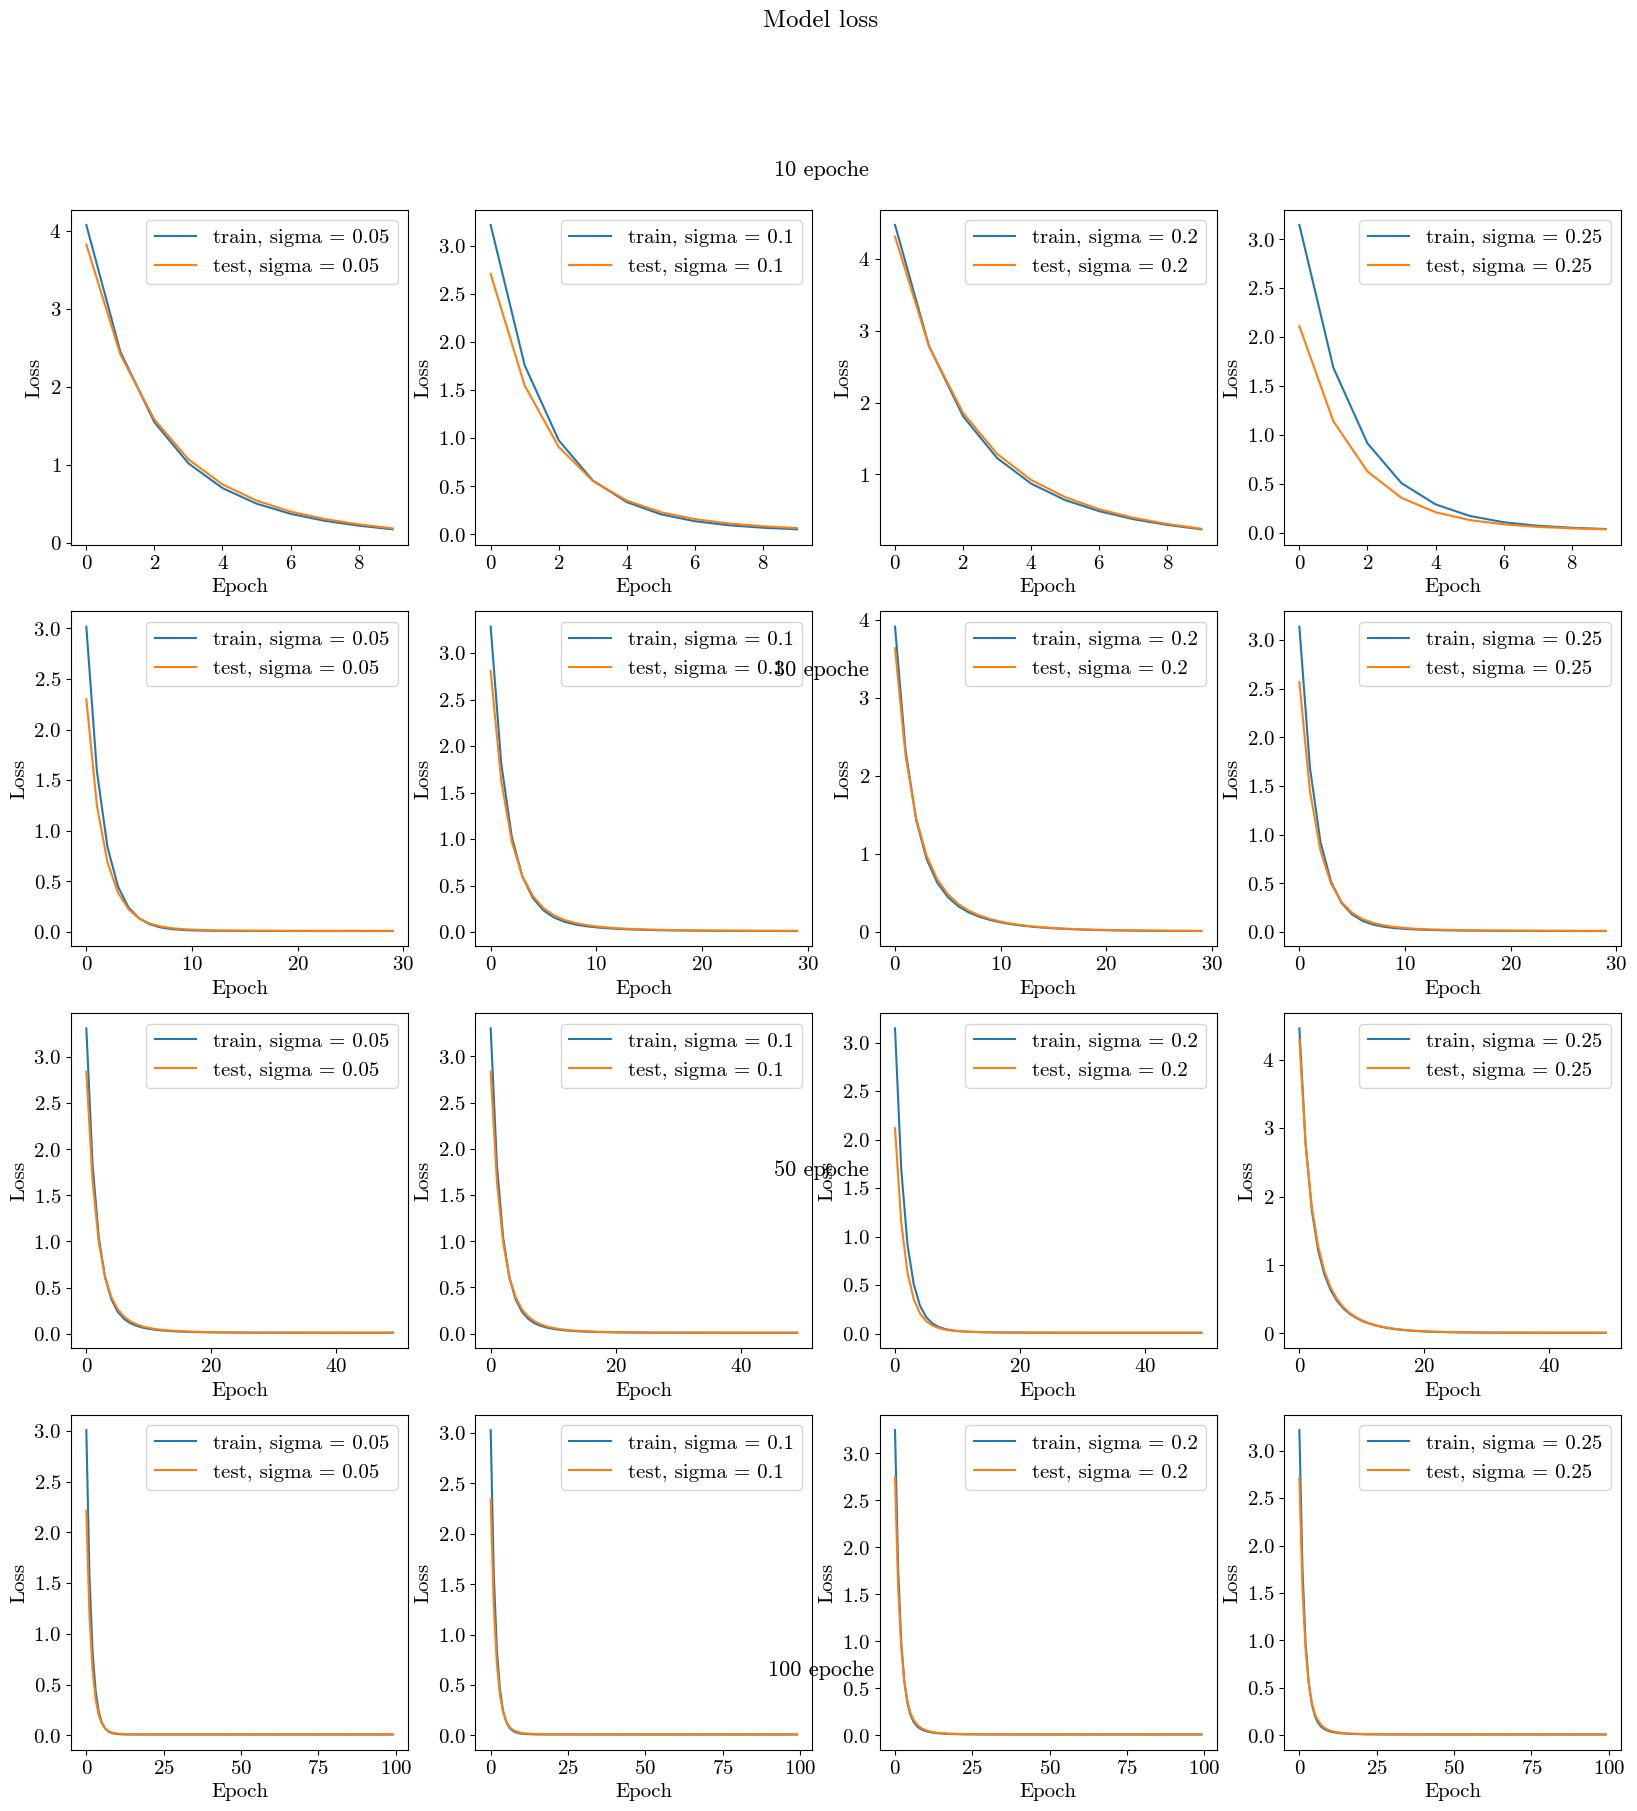

In [ ]:
# look into training history
# Plot training & validation loss values
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Model loss')
for i in range (4): #ciclo su vari valori di n_epochs
    for j in range(4): #ciclo su vari valori di sigma
        x_valid, y_target, model, loss, val_loss = training_validation(500,1,N_epochs[i],sigma[j], 0, 0, 1, 2)
        #plt.subplot(3,3,i+j+1)
        ax = axes[i,j]
        ax.plot(loss, label = f'train, sigma = {sigma[j]}')
        ax.plot(val_loss, label = f'test, sigma = {sigma[j]}')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend()
# Aggiungi un titolo centrato sopra ogni riga
#for i in range(4):
#    # posizionamento orizzontale (metà figura) e verticale dipende dall'indice
#    y = 0.90 - i * (1/4)  # 1/4 = passo verticale in figura normalizzata
#    fig.text(
#        0.5, y,
#        f'{N_epochs[i]} epoche',
#        ha='center',
#        va='center',
#        fontsize=16,
#        fontweight='bold'
#    )

Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 3.6154 - mse: 3.6154 - val_loss: 2.5550 - val_mse: 2.5550
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.4127 - mse: 2.4127 - val_loss: 1.6960 - val_mse: 1.6960
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6115 - mse: 1.6115 - val_loss: 1.1244 - val_mse: 1.1244
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.0986 - mse: 1.0986 - val_loss: 0.7448 - val_mse: 0.7448
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7350 - mse: 0.7350 - val_loss: 0.4926 - val_mse: 0.4926
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4860 - mse: 0.4860 - val_loss: 0.3252 - val_mse: 0.3252
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3351 - mse: 0.3351 - val_loss: 0.2147 - val_mse: 0.2147
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2197 - mse: 0.2197 - val_loss: 0.1421 - val_mse: 0.1421
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1475 - mse:

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 5.1990 - mse: 5.1990 - val_loss: 3.2762 - val_mse: 3.2762
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.5104 - mse: 3.5104 - val_loss: 2.3940 - val_mse: 2.3940
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7919 - mse: 2.7919 - val_loss: 1.7762 - val_mse: 1.7762
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.9773 - mse: 1.9773 - val_loss: 1.3507 - val_mse: 1.3507
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5033 - mse: 1.5033 - val_loss: 1.0388 - val_mse: 1.0388
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2910 - mse: 1.2910 - val_loss: 0.8177 - val_mse: 0.8177
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.0239 - mse: 1.0239 - val_loss: 0.6640 - val_mse: 0.6640
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8183 - mse: 0.8183 - val_loss: 0.5474 - val_mse: 0.5474
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6316 - mse:

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_18 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.6606 - mse: 3.6606 - val_loss: 2.4893 - val_mse: 2.4893
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.5162 - mse: 2.5162 - val_loss: 1.6515 - val_mse: 1.6515
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6945 - mse: 1.6945 - val_loss: 1.0991 - val_mse: 1.0991
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1579 - mse: 1.1579 - val_loss: 0.7316 - val_mse: 0.7316
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7872 - mse: 0.7872 - val_loss: 0.4881 - val_mse: 0.4881
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5368 - mse: 0.5368 - val_loss: 0.3304 - val_mse: 0.3304
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3929 - mse: 0.3929 - val_loss: 0.2237 - val_mse: 0.2237
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2541 - mse: 0.2541 - val_loss: 0.1530 - val_mse: 0.1530
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.1837 - mse:

Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 3.7916 - mse: 3.7916 - val_loss: 2.8429 - val_mse: 2.8429
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5375 - mse: 2.5375 - val_loss: 1.9347 - val_mse: 1.9347
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7193 - mse: 1.7193 - val_loss: 1.3270 - val_mse: 1.3270
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1515 - mse: 1.1515 - val_loss: 0.9100 - val_mse: 0.9100
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7760 - mse: 0.7760 - val_loss: 0.6283 - val_mse: 0.6283
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5466 - mse: 0.5466 - val_loss: 0.4361 - val_mse: 0.4361
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3849 - mse: 0.3849 - val_loss: 0.3088 - val_mse: 0.3088
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.2711 - mse: 0.2711 - val_loss: 0.2202 - val_mse: 0.2202
Epoch 9/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1903 - mse:

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 5.0621 - mse: 5.0621 - val_loss: 4.4362 - val_mse: 4.4362
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.0364 - mse: 3.0364 - val_loss: 2.8676 - val_mse: 2.8676
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.1262 - mse: 2.1262 - val_loss: 1.9271 - val_mse: 1.9271
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.4117 - mse: 1.4117 - val_loss: 1.3521 - val_mse: 1.3521
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9878 - mse: 0.9878 - val_loss: 0.9751 - val_mse: 0.9751
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7619 - mse: 0.7619 - val_loss: 0.7201 - val_mse: 0.7201
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5626 - mse: 0.5626 - val_loss: 0.5452 - val_mse: 0.5452
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4297 - mse: 0.4297 - val_loss: 0.4199 - val_mse: 0.4199
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3277 - mse:

Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_21 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.5848 - mse: 3.5848 - val_loss: 2.7408 - val_mse: 2.7408
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.0158 - mse: 2.0158 - val_loss: 1.5767 - val_mse: 1.5767
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0915 - mse: 1.0915 - val_loss: 0.9351 - val_mse: 0.9351
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6580 - mse: 0.6580 - val_loss: 0.5713 - val_mse: 0.5713
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3687 - mse: 0.3687 - val_loss: 0.3639 - val_mse: 0.3639
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2190 - mse: 0.2190 - val_loss: 0.2396 - val_mse: 0.2396
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1533 - mse: 0.1533 - val_loss: 0.1651 - val_mse: 0.1651
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1124 - mse: 0.1124 - val_loss: 0.1190 - val_mse: 0.1190
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0788 - mse: 

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.5780 - mse: 3.5780 - val_loss: 2.6858 - val_mse: 2.6858
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.9937 - mse: 1.9937 - val_loss: 1.5333 - val_mse: 1.5333
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0597 - mse: 1.0597 - val_loss: 0.8975 - val_mse: 0.8975
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6106 - mse: 0.6106 - val_loss: 0.5416 - val_mse: 0.5416
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3674 - mse: 0.3674 - val_loss: 0.3393 - val_mse: 0.3393
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2199 - mse: 0.2199 - val_loss: 0.2218 - val_mse: 0.2218
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1483 - mse: 0.1483 - val_loss: 0.1518 - val_mse: 0.1518
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0945 - mse: 0.0945 - val_loss: 0.1079 - val_mse: 0.1079
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0684 - mse:

Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_23 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.6756 - mse: 3.6756 - val_loss: 2.6409 - val_mse: 2.6409
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.9135 - mse: 1.9135 - val_loss: 1.5005 - val_mse: 1.5005
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0128 - mse: 1.0128 - val_loss: 0.8708 - val_mse: 0.8708
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6129 - mse: 0.6129 - val_loss: 0.5210 - val_mse: 0.5210
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3397 - mse: 0.3397 - val_loss: 0.3242 - val_mse: 0.3242
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2038 - mse: 0.2038 - val_loss: 0.2108 - val_mse: 0.2108
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1365 - mse: 0.1365 - val_loss: 0.1432 - val_mse: 0.1432
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0852 - mse: 0.0852 - val_loss: 0.1016 - val_mse: 0.1016
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0637 - mse:

Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_24 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8790 - mse: 4.8790 - val_loss: 2.6353 - val_mse: 2.6353
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2.0052 - mse: 2.0052 - val_loss: 1.2605 - val_mse: 1.2605
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0448 - mse: 1.0448 - val_loss: 0.7053 - val_mse: 0.7053
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6152 - mse: 0.6152 - val_loss: 0.4310 - val_mse: 0.4310
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3937 - mse: 0.3937 - val_loss: 0.2754 - val_mse: 0.2754
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2380 - mse: 0.2380 - val_loss: 0.1796 - val_mse: 0.1796
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1599 - mse: 0.1599 - val_loss: 0.1201 - val_mse: 0.1201
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1048 - mse: 0.1048 - val_loss: 0.0816 - val_mse: 0.0816
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0699 - mse: 

Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_25 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2180 - mse: 3.2180 - val_loss: 1.1019 - val_mse: 1.1019
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9324 - mse: 0.9324 - val_loss: 0.3199 - val_mse: 0.3199
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2874 - mse: 0.2874 - val_loss: 0.1036 - val_mse: 0.1036
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1177 - mse: 0.1177 - val_loss: 0.0420 - val_mse: 0.0420
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0481 - mse: 0.0481 - val_loss: 0.0227 - val_mse: 0.0227
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0156 - val_mse: 0.0156
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 - mse: 0.0209 - val_loss: 0.0124 - val_mse: 0.0124
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - mse: 0.0168 - val_loss: 0.0107 - val_mse: 0.0107
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - mse: 

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_26 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.3944 - mse: 3.3944 - val_loss: 1.4207 - val_mse: 1.4207
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.1336 - mse: 1.1336 - val_loss: 0.5129 - val_mse: 0.5129
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4206 - mse: 0.4206 - val_loss: 0.2239 - val_mse: 0.2239
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1794 - mse: 0.1794 - val_loss: 0.1164 - val_mse: 0.1164
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0995 - mse: 0.0995 - val_loss: 0.0713 - val_mse: 0.0713
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0633 - mse: 0.0633 - val_loss: 0.0475 - val_mse: 0.0475
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0418 - mse: 0.0418 - val_loss: 0.0341 - val_mse: 0.0341
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0298 - mse: 0.0298 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0218 - mse: 

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.3535 - mse: 4.3535 - val_loss: 2.1394 - val_mse: 2.1394
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7449 - mse: 1.7449 - val_loss: 0.9633 - val_mse: 0.9633
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7404 - mse: 0.7404 - val_loss: 0.5113 - val_mse: 0.5113
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4704 - mse: 0.4704 - val_loss: 0.3008 - val_mse: 0.3008
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2645 - mse: 0.2645 - val_loss: 0.1918 - val_mse: 0.1918
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1678 - mse: 0.1678 - val_loss: 0.1268 - val_mse: 0.1268
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1064 - mse: 0.1064 - val_loss: 0.0856 - val_mse: 0.0856
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0745 - mse: 0.0745 - val_loss: 0.0593 - val_mse: 0.0593
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0531 - mse: 

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.3697 - mse: 3.3697 - val_loss: 0.8357 - val_mse: 0.8357
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6995 - mse: 0.6995 - val_loss: 0.2442 - val_mse: 0.2442
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2287 - mse: 0.2287 - val_loss: 0.1084 - val_mse: 0.1084
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0989 - mse: 0.0989 - val_loss: 0.0601 - val_mse: 0.0601
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0528 - mse: 0.0528 - val_loss: 0.0373 - val_mse: 0.0373
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0313 - mse: 0.0313 - val_loss: 0.0253 - val_mse: 0.0253
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0215 - mse: 0.0215 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0125 - mse: 

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_29 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.2539 - mse: 4.2539 - val_loss: 1.3113 - val_mse: 1.3113
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2240 - mse: 1.2240 - val_loss: 0.5068 - val_mse: 0.5068
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4879 - mse: 0.4879 - val_loss: 0.2498 - val_mse: 0.2498
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2365 - mse: 0.2365 - val_loss: 0.1361 - val_mse: 0.1361
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1200 - mse: 0.1200 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0666 - mse: 0.0666 - val_loss: 0.0470 - val_mse: 0.0470
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0399 - mse: 0.0399 - val_loss: 0.0304 - val_mse: 0.0304
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0239 - mse: 0.0239 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0170 - mse: 

Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_30 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9436 - mse: 3.9436 - val_loss: 1.1416 - val_mse: 1.1416
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0079 - mse: 1.0079 - val_loss: 0.4133 - val_mse: 0.4133
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4108 - mse: 0.4108 - val_loss: 0.1999 - val_mse: 0.1999
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1852 - mse: 0.1852 - val_loss: 0.1092 - val_mse: 0.1092
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0945 - mse: 0.0945 - val_loss: 0.0635 - val_mse: 0.0635
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0547 - mse: 0.0547 - val_loss: 0.0393 - val_mse: 0.0393
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0332 - mse: 0.0332 - val_loss: 0.0263 - val_mse: 0.0263
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0218 - mse: 0.0218 - val_loss: 0.0192 - val_mse: 0.0192
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0146 - mse: 

Model: "sequential_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 2.7204 - mse: 2.7204 - val_loss: 0.5855 - val_mse: 0.5855
Epoch 2/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4216 - mse: 0.4216 - val_loss: 0.0961 - val_mse: 0.0961
Epoch 3/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0776 - mse: 0.0776 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 4/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0235 - mse: 0.0235 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 5/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0131 - mse: 0.0131 - val_loss: 0.0117 - val_mse: 0.0117
Epoch 6/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0111 - mse: 0.0111 - val_loss: 0.0110 - val_mse: 0.0110
Epoch 7/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0106 - val_mse: 0.0106
Epoch 8/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0100 - mse: 0.0100 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 9/50
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0094 - mse: 

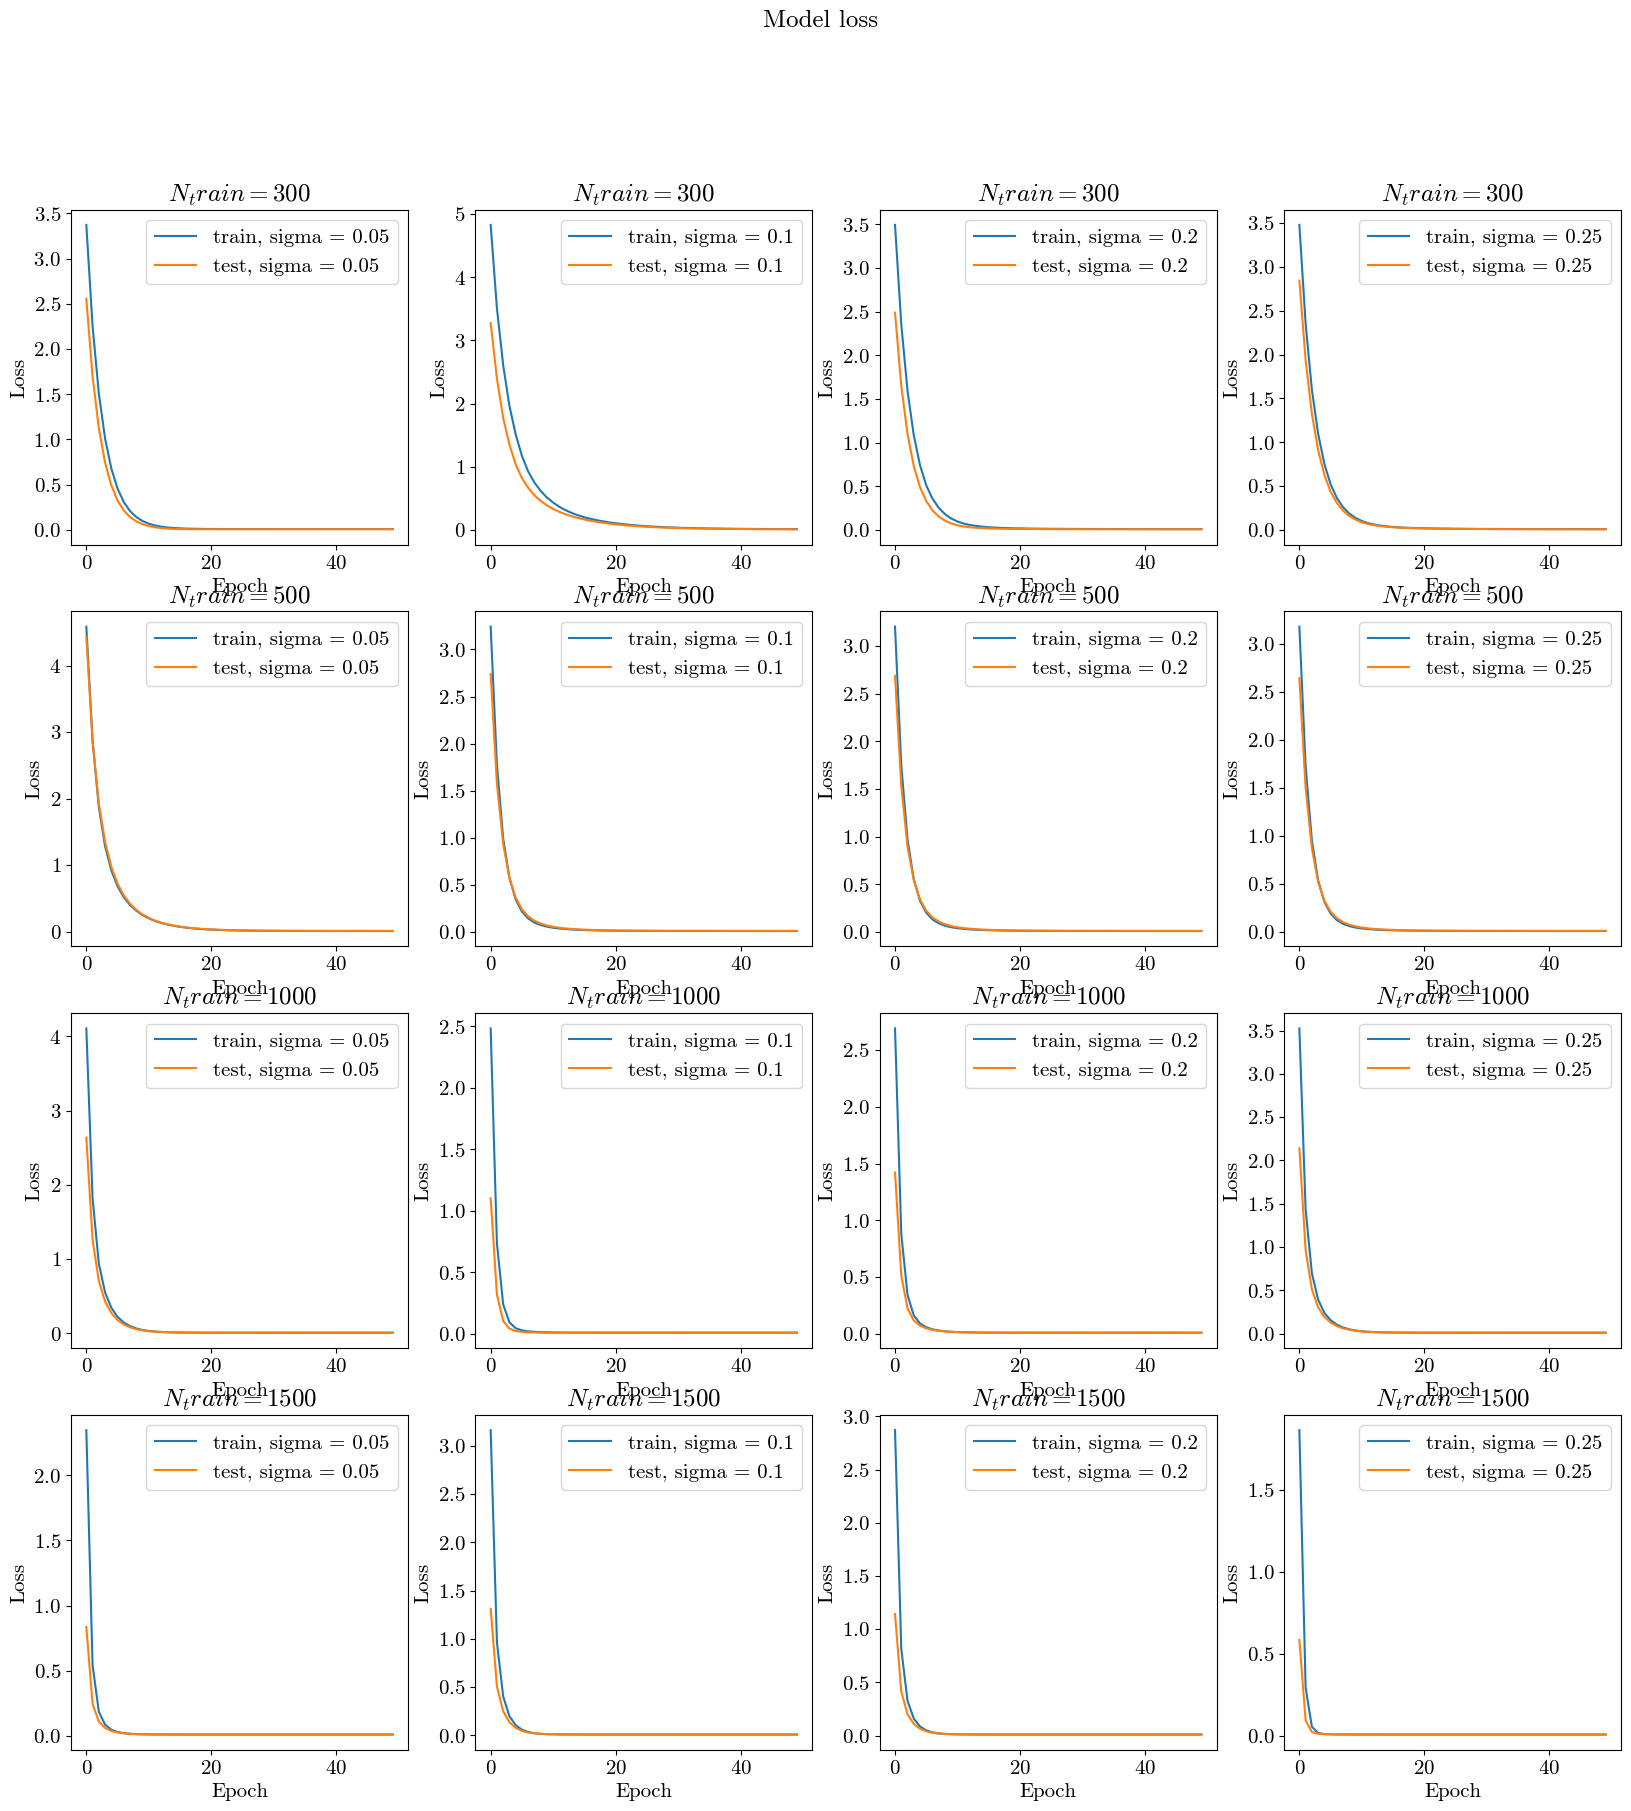

In [ ]:
# look into training history
# Plot training & validation loss values
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig.suptitle('Model loss')
for i in range (4): #ciclo su vari valori di n_train
    for j in range(4): #ciclo su vari valori di sigma
        x_valid, y_target, model, loss, val_loss = training_validation(N_train[i],1,50,sigma[j], 0, 0, 1, 2)
        #plt.subplot(3,3,i+j+1)
        ax = axes[i,j]
        ax.plot(loss, label = f'train, sigma = {sigma[j]}')
        ax.plot(val_loss, label = f'test, sigma = {sigma[j]}')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.set_title(f'$N_{train} = {N_train[i]}$')
        ax.legend()


Osserviamo che il risulato migliore è ottenuto per un training con il mggior nuemro di epoche e una sigma bassa. Utilizzando i valori di $\sigma$ e $N_{epochs}$ migliori grafichiamo i punti predetti dal modello e li confrontiamo con quelli  della funzione.

Parametri:
- $N_{train} = 1000$
- $N_{epochs} = 100$
- $\sigma = 0.05$

In [6]:
x_valid_best, y_target_best,model_best, loss_best, val_loss_best = training_validation(1000,1,100,0.05,0,0,1,2)

Model: "sequential_32"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2 (8.00 B)

 Trainable params: 2 (8.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 3.7331 - mse: 3.7331 - val_loss: 1.6107 - val_mse: 1.6107
Epoch 2/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2172 - mse: 1.2172 - val_loss: 0.6256 - val_mse: 0.6256
Epoch 3/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4929 - mse: 0.4929 - val_loss: 0.2912 - val_mse: 0.2912
Epoch 4/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2404 - mse: 0.2404 - val_loss: 0.1621 - val_mse: 0.1621
Epoch 5/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1497 - mse: 0.1497 - val_loss: 0.0996 - val_mse: 0.0996
Epoch 6/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0899 - mse: 0.0899 - val_loss: 0.0660 - val_mse: 0.0660
Epoch 7/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0561 - mse: 0.0561 - val_loss: 0.0458 - val_mse: 0.0458
Epoch 8/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - mse: 0.0426 - val_loss: 0.0334 - val_mse: 0.0334
Epoch 9/100
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.028

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


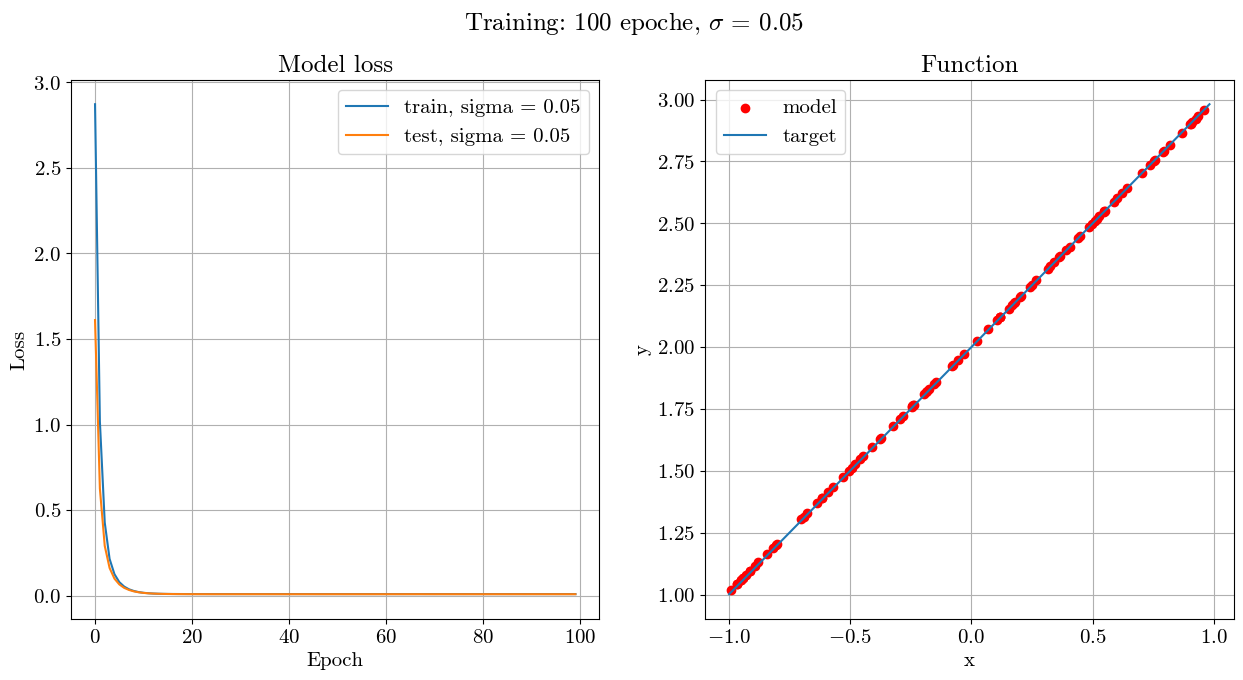

In [ ]:

x_predicted = np.random.uniform(-1, 1, 100)
y_predicted = model_best.predict(x_predicted)

fig = plt.figure(1, figsize=(15,7))
fig.suptitle('Training con 1000 putni, 100 epoche, $\sigma$ = 0.05')
plt.subplot(1,2,1)
plt.plot(loss_best, label = f'train, sigma = 0.05')
plt.plot(val_loss_best, label = f'test, sigma = 0.05')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Model loss')
plt.legend()
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(x_predicted, y_predicted,color='r', label = 'model')
plt.plot(x_valid_best, y_target_best, label = 'target')
plt.ylabel('y')
plt.xlabel('x')
plt.title('Function')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 11.2

Try to extend the model to obtain a reasonable fit of the following polynomial of order 3:

$$
f(x)=4-3x-2x^2+3x^3
$$
for $x \in [-1,1]$.

Find good (& reasonable) choices for:

- the number of layers
- the number of neurons in each layer
- the activation function
- the optimizer
- the loss function
  
Check your NN model by seeing how well your fits predict newly generated test data (including on data outside the range you fit. How well do your NN do on points in the range of $x$ where you trained the model? How about points outside the original training data set? 
Summarize what you have learned about the relationship between model complexity (number of parameters), goodness of fit on training data, and the ability to predict well.

#### Soluzione 11.2

In [8]:
# target parameters of f(x) = ax^3 +b x^2 +c x +d
a = 3 
b = -2
c = - 3
d = 4

In questo caso i parametri da fittare sono 4 quindi non basta una rete neurale con un solo layer perchè essa è in grado di predire solo due parametri. Quindi aggiungiamo dei layer al modello precedente, ciascuno con un certo nuermo di neuroni e con una funzione di attivazione (nel nostro caso la ``` relu```). Facciamo variare il numero di epoche e per ogni valore facciamo diversi allenamenti, ciascuno con una sigma diversa nella creazione del dataset di training iniziale.

Model: "sequential_66"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_198 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_199 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_200 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_201 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_202 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 9.9299 - mse: 9.9299 - val_loss: 2.1711 - val_mse: 2.1711
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.3890 - mse: 1.3890 - val_loss: 1.0154 - val_mse: 1.0154
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8776 - mse: 0.8776 - val_loss: 0.8633 - val_mse: 0.8633
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.7030 - mse: 0.7030 - val_loss: 0.7065 - val_mse: 0.7065
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6233 - mse: 0.6233 - val_loss: 0.5763 - val_mse: 0.5763
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5200 - mse: 0.5200 - val_loss: 0.5307 - val_mse: 0.5307
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4505 - mse: 0.4505 - val_loss: 0.4217 - val_mse: 0.4217
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3998 - mse: 0.3998 - val_loss: 0.4026 - val_mse: 0.4026
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4018 - mse:

Model: "sequential_67"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_203 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_204 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_205 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_206 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_207 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 9.2657 - mse: 9.2657 - val_loss: 2.2552 - val_mse: 2.2552
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7790 - mse: 1.7790 - val_loss: 1.3298 - val_mse: 1.3298
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0010 - mse: 1.0010 - val_loss: 0.9722 - val_mse: 0.9722
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7669 - mse: 0.7669 - val_loss: 0.7586 - val_mse: 0.7586
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6516 - mse: 0.6516 - val_loss: 0.6067 - val_mse: 0.6067
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5349 - mse: 0.5349 - val_loss: 0.4948 - val_mse: 0.4948
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4555 - mse: 0.4555 - val_loss: 0.4463 - val_mse: 0.4463
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4904 - mse: 0.4904 - val_loss: 0.3712 - val_mse: 0.3712
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3901 - mse:

Model: "sequential_68"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_208 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_209 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_210 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_211 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_212 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.7816 - mse: 7.7816 - val_loss: 1.0440 - val_mse: 1.0440
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8802 - mse: 0.8802 - val_loss: 0.7828 - val_mse: 0.7828
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7092 - mse: 0.7092 - val_loss: 0.6429 - val_mse: 0.6429
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6627 - mse: 0.6627 - val_loss: 0.5489 - val_mse: 0.5489
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5312 - mse: 0.5312 - val_loss: 0.4830 - val_mse: 0.4830
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5224 - mse: 0.5224 - val_loss: 0.4311 - val_mse: 0.4311
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4135 - mse: 0.4135 - val_loss: 0.3877 - val_mse: 0.3877
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4307 - mse: 0.4307 - val_loss: 0.3441 - val_mse: 0.3441
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3521 - mse:

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_213 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_214 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_215 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_216 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_217 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9789 - mse: 9.9789 - val_loss: 3.6239 - val_mse: 3.6239
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5582 - mse: 2.5582 - val_loss: 1.0020 - val_mse: 1.0020
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7923 - mse: 0.7923 - val_loss: 0.7655 - val_mse: 0.7655
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6763 - mse: 0.6763 - val_loss: 0.6154 - val_mse: 0.6154
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5097 - mse: 0.5097 - val_loss: 0.5188 - val_mse: 0.5188
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5134 - mse: 0.5134 - val_loss: 0.4519 - val_mse: 0.4519
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3928 - mse: 0.3928 - val_loss: 0.4110 - val_mse: 0.4110
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4130 - mse: 0.4130 - val_loss: 0.3560 - val_mse: 0.3560
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3540 - mse:

Model: "sequential_70"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_218 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_219 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_220 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_221 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_222 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.3685 - mse: 10.3685 - val_loss: 2.6932 - val_mse: 2.6932
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7851 - mse: 1.7851 - val_loss: 1.0962 - val_mse: 1.0962
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9151 - mse: 0.9151 - val_loss: 0.9053 - val_mse: 0.9053
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7291 - mse: 0.7291 - val_loss: 0.7331 - val_mse: 0.7331
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5946 - mse: 0.5946 - val_loss: 0.5679 - val_mse: 0.5679
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4978 - mse: 0.4978 - val_loss: 0.4218 - val_mse: 0.4218
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3965 - mse: 0.3965 - val_loss: 0.3464 - val_mse: 0.3464
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3681 - mse: 0.3681 - val_loss: 0.3353 - val_mse: 0.3353
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3532 - ms

Model: "sequential_71"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_223 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_224 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_225 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_226 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_227 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 10.5588 - mse: 10.5588 - val_loss: 6.6195 - val_mse: 6.6195
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.0375 - mse: 6.0375 - val_loss: 3.9701 - val_mse: 3.9701
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.9204 - mse: 3.9204 - val_loss: 2.6137 - val_mse: 2.6137
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5139 - mse: 2.5139 - val_loss: 1.9128 - val_mse: 1.9128
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.7542 - mse: 1.7542 - val_loss: 1.5609 - val_mse: 1.5609
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.5331 - mse: 1.5331 - val_loss: 1.3919 - val_mse: 1.3919
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2294 - mse: 1.2294 - val_loss: 1.3054 - val_mse: 1.3054
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.2046 - mse: 1.2046 - val_loss: 1.2675 - val_mse: 1.2675
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1048 - ms

Model: "sequential_72"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_228 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_229 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_230 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_231 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_232 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 7.8206 - mse: 7.8206 - val_loss: 1.2002 - val_mse: 1.2002
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9393 - mse: 0.9393 - val_loss: 0.7770 - val_mse: 0.7770
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6816 - mse: 0.6816 - val_loss: 0.5621 - val_mse: 0.5621
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4826 - mse: 0.4826 - val_loss: 0.4398 - val_mse: 0.4398
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4069 - mse: 0.4069 - val_loss: 0.3796 - val_mse: 0.3796
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4053 - mse: 0.4053 - val_loss: 0.3772 - val_mse: 0.3772
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3788 - mse: 0.3788 - val_loss: 0.3560 - val_mse: 0.3560
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3716 - mse: 0.3716 - val_loss: 0.3641 - val_mse: 0.3641
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3681 - mse:

Model: "sequential_73"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_233 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_234 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_235 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_236 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_237 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 9.4553 - mse: 9.4553 - val_loss: 2.2800 - val_mse: 2.2800
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6766 - mse: 1.6766 - val_loss: 0.8669 - val_mse: 0.8669
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6238 - mse: 0.6238 - val_loss: 0.3747 - val_mse: 0.3747
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3094 - mse: 0.3094 - val_loss: 0.2483 - val_mse: 0.2483
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2604 - mse: 0.2604 - val_loss: 0.2359 - val_mse: 0.2359
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2389 - mse: 0.2389 - val_loss: 0.2215 - val_mse: 0.2215
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2562 - mse: 0.2562 - val_loss: 0.2185 - val_mse: 0.2185
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2402 - mse: 0.2402 - val_loss: 0.2304 - val_mse: 0.2304
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2671 - mse:

Model: "sequential_74"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_238 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_239 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_240 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_241 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_242 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.3755 - mse: 7.3755 - val_loss: 1.6238 - val_mse: 1.6238
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2374 - mse: 1.2374 - val_loss: 1.0552 - val_mse: 1.0552
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8463 - mse: 0.8463 - val_loss: 0.7509 - val_mse: 0.7509
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5870 - mse: 0.5870 - val_loss: 0.4968 - val_mse: 0.4968
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4421 - mse: 0.4421 - val_loss: 0.3378 - val_mse: 0.3378
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2765 - mse: 0.2765 - val_loss: 0.2975 - val_mse: 0.2975
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3221 - mse: 0.3221 - val_loss: 0.2373 - val_mse: 0.2373
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2523 - mse: 0.2523 - val_loss: 0.1986 - val_mse: 0.1986
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2057 - mse:

Model: "sequential_75"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_243 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_244 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_245 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_246 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_247 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.8286 - mse: 9.8286 - val_loss: 3.5288 - val_mse: 3.5288
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.4372 - mse: 2.4372 - val_loss: 1.0882 - val_mse: 1.0882
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8125 - mse: 0.8125 - val_loss: 0.6062 - val_mse: 0.6062
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5150 - mse: 0.5150 - val_loss: 0.3797 - val_mse: 0.3797
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3608 - mse: 0.3608 - val_loss: 0.2797 - val_mse: 0.2797
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2878 - mse: 0.2878 - val_loss: 0.2544 - val_mse: 0.2544
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3127 - mse: 0.3127 - val_loss: 0.2250 - val_mse: 0.2250
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3406 - mse: 0.3406 - val_loss: 0.2356 - val_mse: 0.2356
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2443 - mse:

Model: "sequential_76"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_248 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_249 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_250 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_251 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_252 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.9601 - mse: 9.9601 - val_loss: 4.8296 - val_mse: 4.8296
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.4472 - mse: 3.4472 - val_loss: 1.0732 - val_mse: 1.0732
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8741 - mse: 0.8741 - val_loss: 0.9485 - val_mse: 0.9485
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7843 - mse: 0.7843 - val_loss: 0.8771 - val_mse: 0.8771
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7483 - mse: 0.7483 - val_loss: 0.8112 - val_mse: 0.8112
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7501 - mse: 0.7501 - val_loss: 0.7517 - val_mse: 0.7517
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6612 - mse: 0.6612 - val_loss: 0.7024 - val_mse: 0.7024
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6343 - mse: 0.6343 - val_loss: 0.6603 - val_mse: 0.6603
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5941 - mse:

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_253 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_254 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_255 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_256 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_257 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.3055 - mse: 7.3055 - val_loss: 0.9314 - val_mse: 0.9314
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.7216 - mse: 0.7216 - val_loss: 0.6177 - val_mse: 0.6177
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5205 - mse: 0.5205 - val_loss: 0.5315 - val_mse: 0.5315
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4795 - mse: 0.4795 - val_loss: 0.3844 - val_mse: 0.3844
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4124 - mse: 0.4124 - val_loss: 0.3334 - val_mse: 0.3334
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3442 - mse: 0.3442 - val_loss: 0.3011 - val_mse: 0.3011
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3718 - mse: 0.3718 - val_loss: 0.2907 - val_mse: 0.2907
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2956 - mse: 0.2956 - val_loss: 0.2765 - val_mse: 0.2765
Epoch 9/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.2784 - mse:

Model: "sequential_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_258 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_259 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_260 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_261 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_262 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 10.6404 - mse: 10.6404 - val_loss: 6.6070 - val_mse: 6.6070
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.1340 - mse: 6.1340 - val_loss: 3.9499 - val_mse: 3.9499
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.5620 - mse: 3.5620 - val_loss: 2.5829 - val_mse: 2.5829
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2.3674 - mse: 2.3674 - val_loss: 1.8973 - val_mse: 1.8973
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7486 - mse: 1.7486 - val_loss: 1.5251 - val_mse: 1.5251
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3773 - mse: 1.3773 - val_loss: 1.3096 - val_mse: 1.3096
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1136 - mse: 1.1136 - val_loss: 1.1888 - val_mse: 1.1888
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.0611 - mse: 1.0611 - val_loss: 1.1068 - val_mse: 1.1068
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.

Model: "sequential_79"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_263 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_264 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_265 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_266 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_267 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 9.8389 - mse: 9.8389 - val_loss: 1.5771 - val_mse: 1.5771
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.1325 - mse: 1.1325 - val_loss: 0.9090 - val_mse: 0.9090
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.7721 - mse: 0.7721 - val_loss: 0.8271 - val_mse: 0.8271
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6856 - mse: 0.6856 - val_loss: 0.7288 - val_mse: 0.7288
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6318 - mse: 0.6318 - val_loss: 0.6436 - val_mse: 0.6436
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6150 - mse: 0.6150 - val_loss: 0.5568 - val_mse: 0.5568
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5178 - mse: 0.5178 - val_loss: 0.4776 - val_mse: 0.4776
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4517 - mse: 0.4517 - val_loss: 0.4285 - val_mse: 0.4285
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.41

Model: "sequential_80"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_268 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_269 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_270 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_271 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_272 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.9019 - mse: 6.9019 - val_loss: 0.8581 - val_mse: 0.8581
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.6906 - mse: 0.6906 - val_loss: 0.6443 - val_mse: 0.6443
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.5723 - mse: 0.5723 - val_loss: 0.5135 - val_mse: 0.5135
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5118 - mse: 0.5118 - val_loss: 0.4500 - val_mse: 0.4500
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4537 - mse: 0.4537 - val_loss: 0.3823 - val_mse: 0.3823
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4183 - mse: 0.4183 - val_loss: 0.3872 - val_mse: 0.3872
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4220 - mse: 0.4220 - val_loss: 0.3365 - val_mse: 0.3365
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.3526 - mse: 0.3526 - val_loss: 0.3195 - val_mse: 0.3195
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.37

Model: "sequential_81"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_273 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_274 (Dense)               │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_275 (Dense)               │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_276 (Dense)               │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_277 (Dense)               │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 433 (1.69 KB)

 Trainable params: 433 (1.69 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 10.7292 - mse: 10.7292 - val_loss: 5.7590 - val_mse: 5.7590
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 4.7267 - mse: 4.7267 - val_loss: 1.7176 - val_mse: 1.7176
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1.2664 - mse: 1.2664 - val_loss: 0.9967 - val_mse: 0.9967
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7807 - mse: 0.7807 - val_loss: 0.7401 - val_mse: 0.7401
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.6008 - mse: 0.6008 - val_loss: 0.5073 - val_mse: 0.5073
Epoch 6/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4276 - mse: 0.4276 - val_loss: 0.3523 - val_mse: 0.3523
Epoch 7/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3399 - mse: 0.3399 - val_loss: 0.2680 - val_mse: 0.2680
Epoch 8/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2606 - mse: 0.2606 - val_loss: 0.2444 - val_mse: 0.2444
Epoch 9/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.

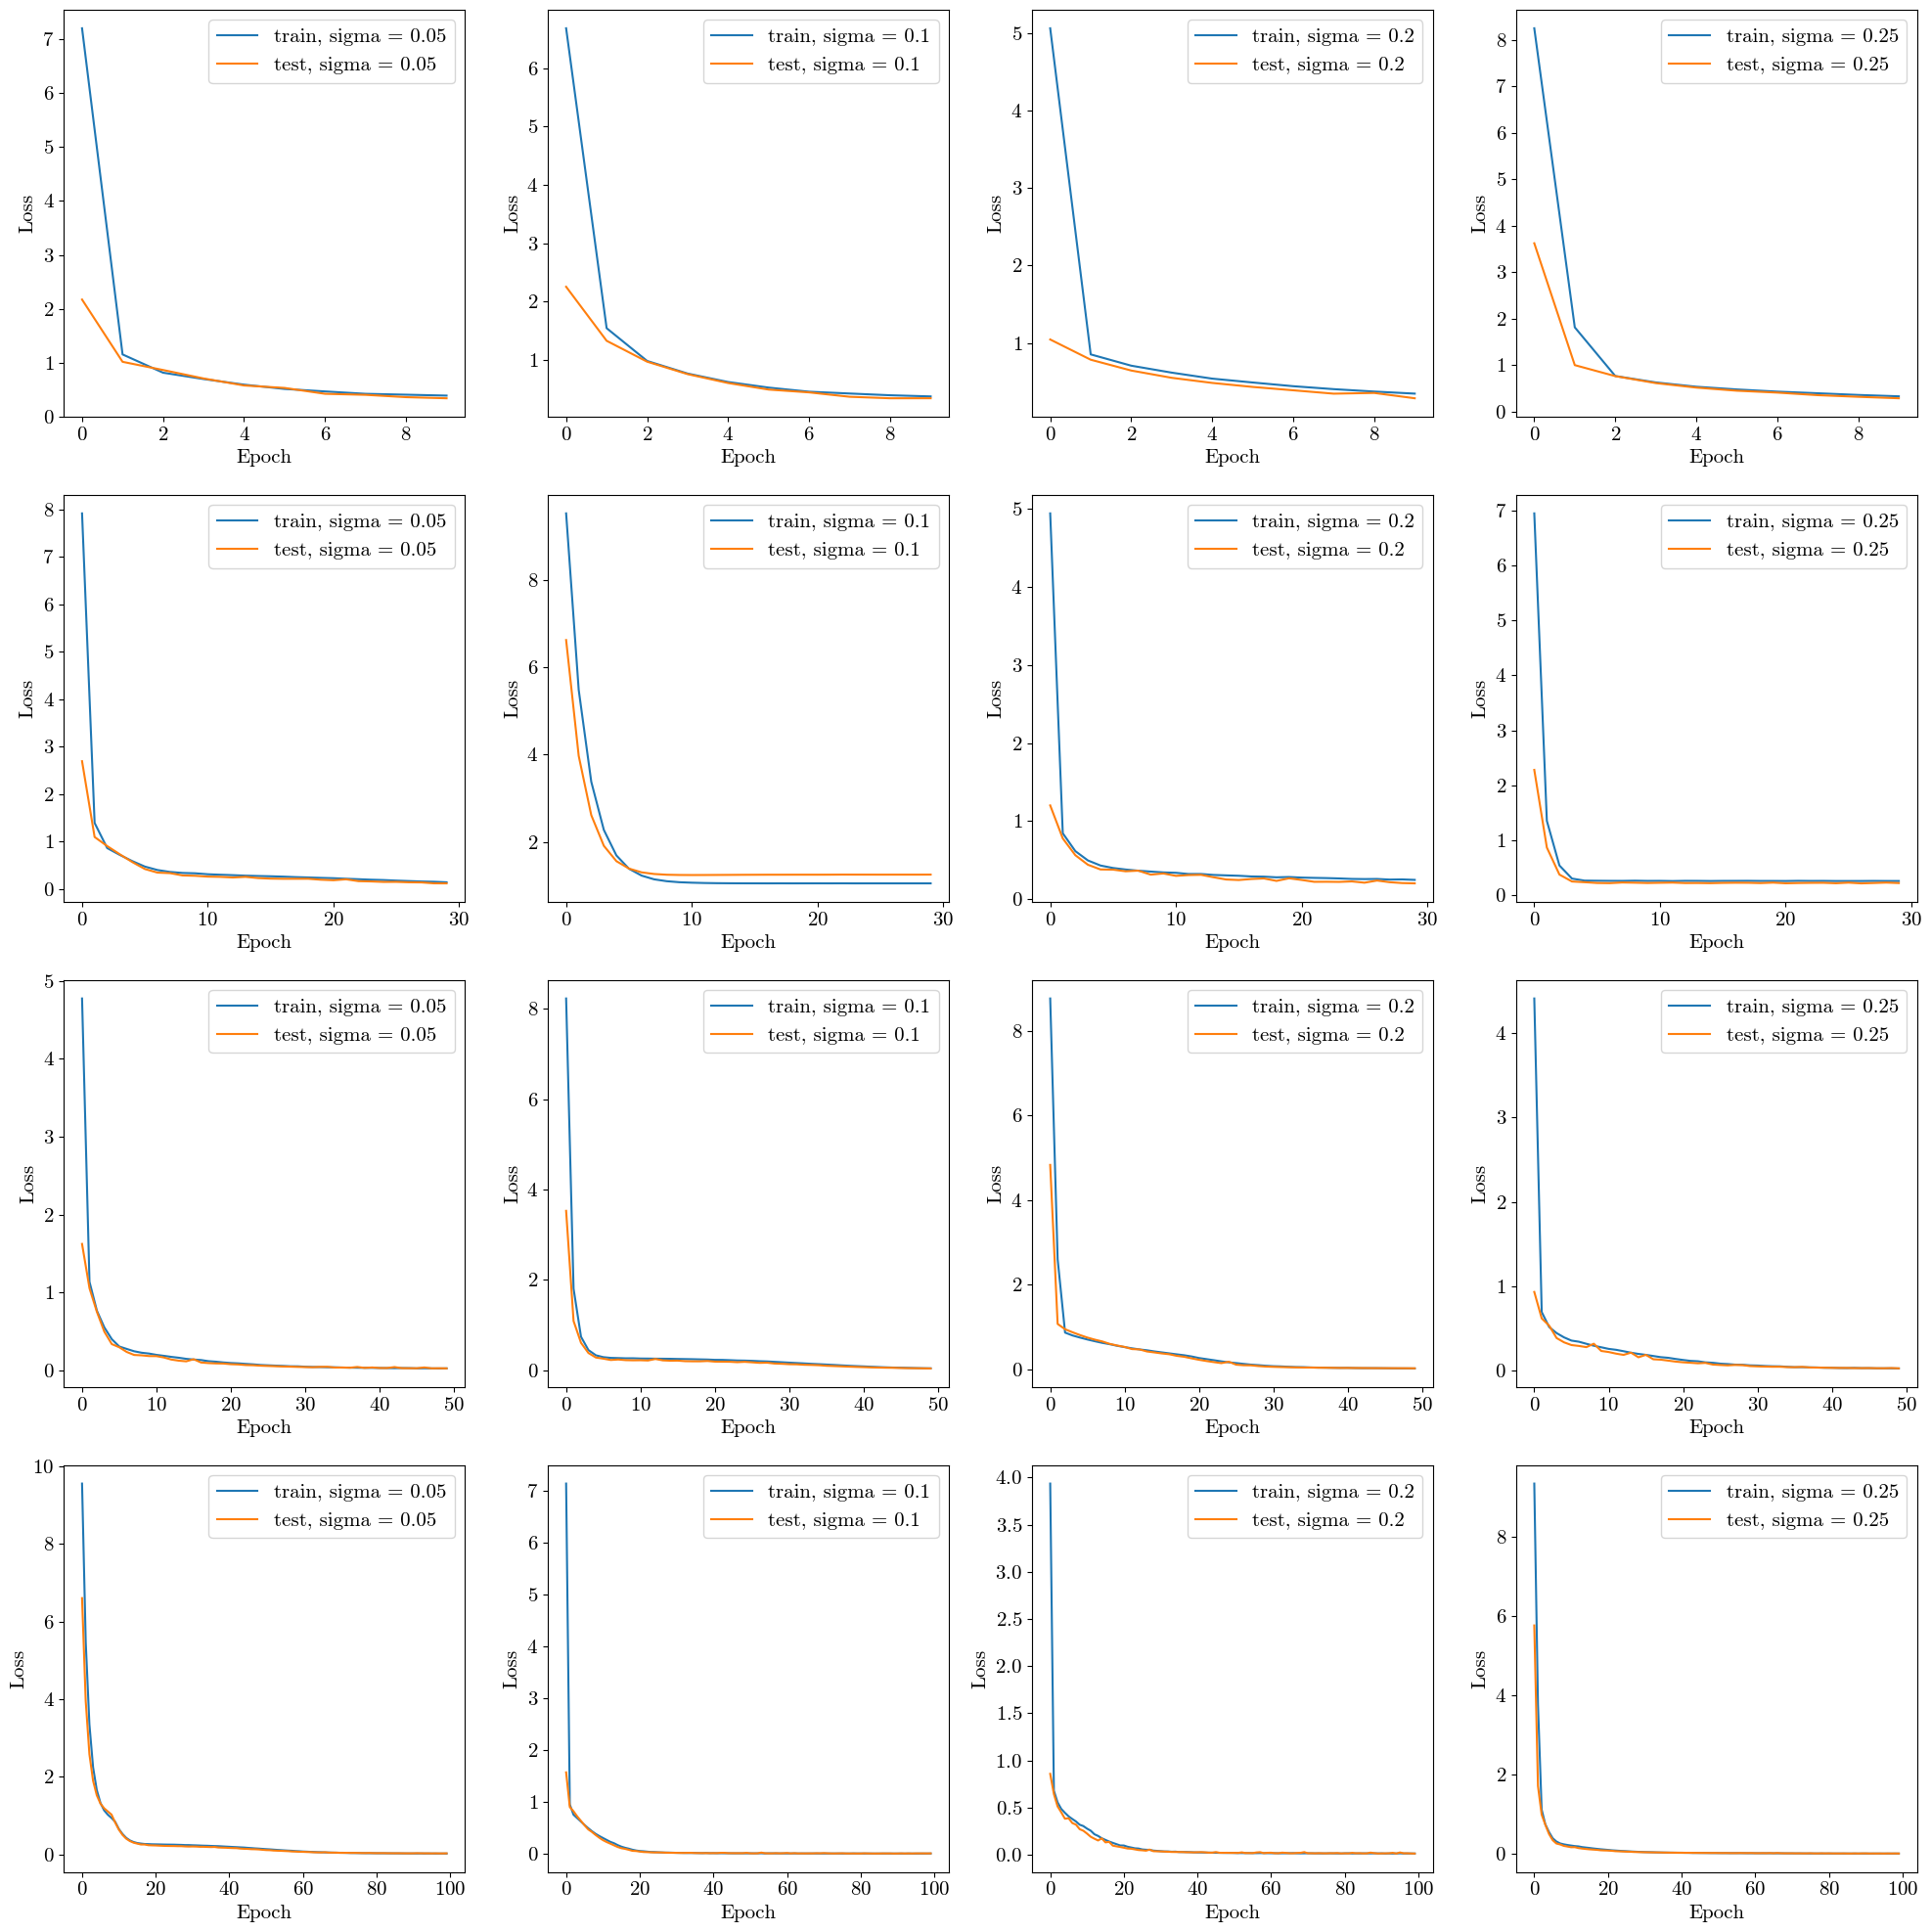

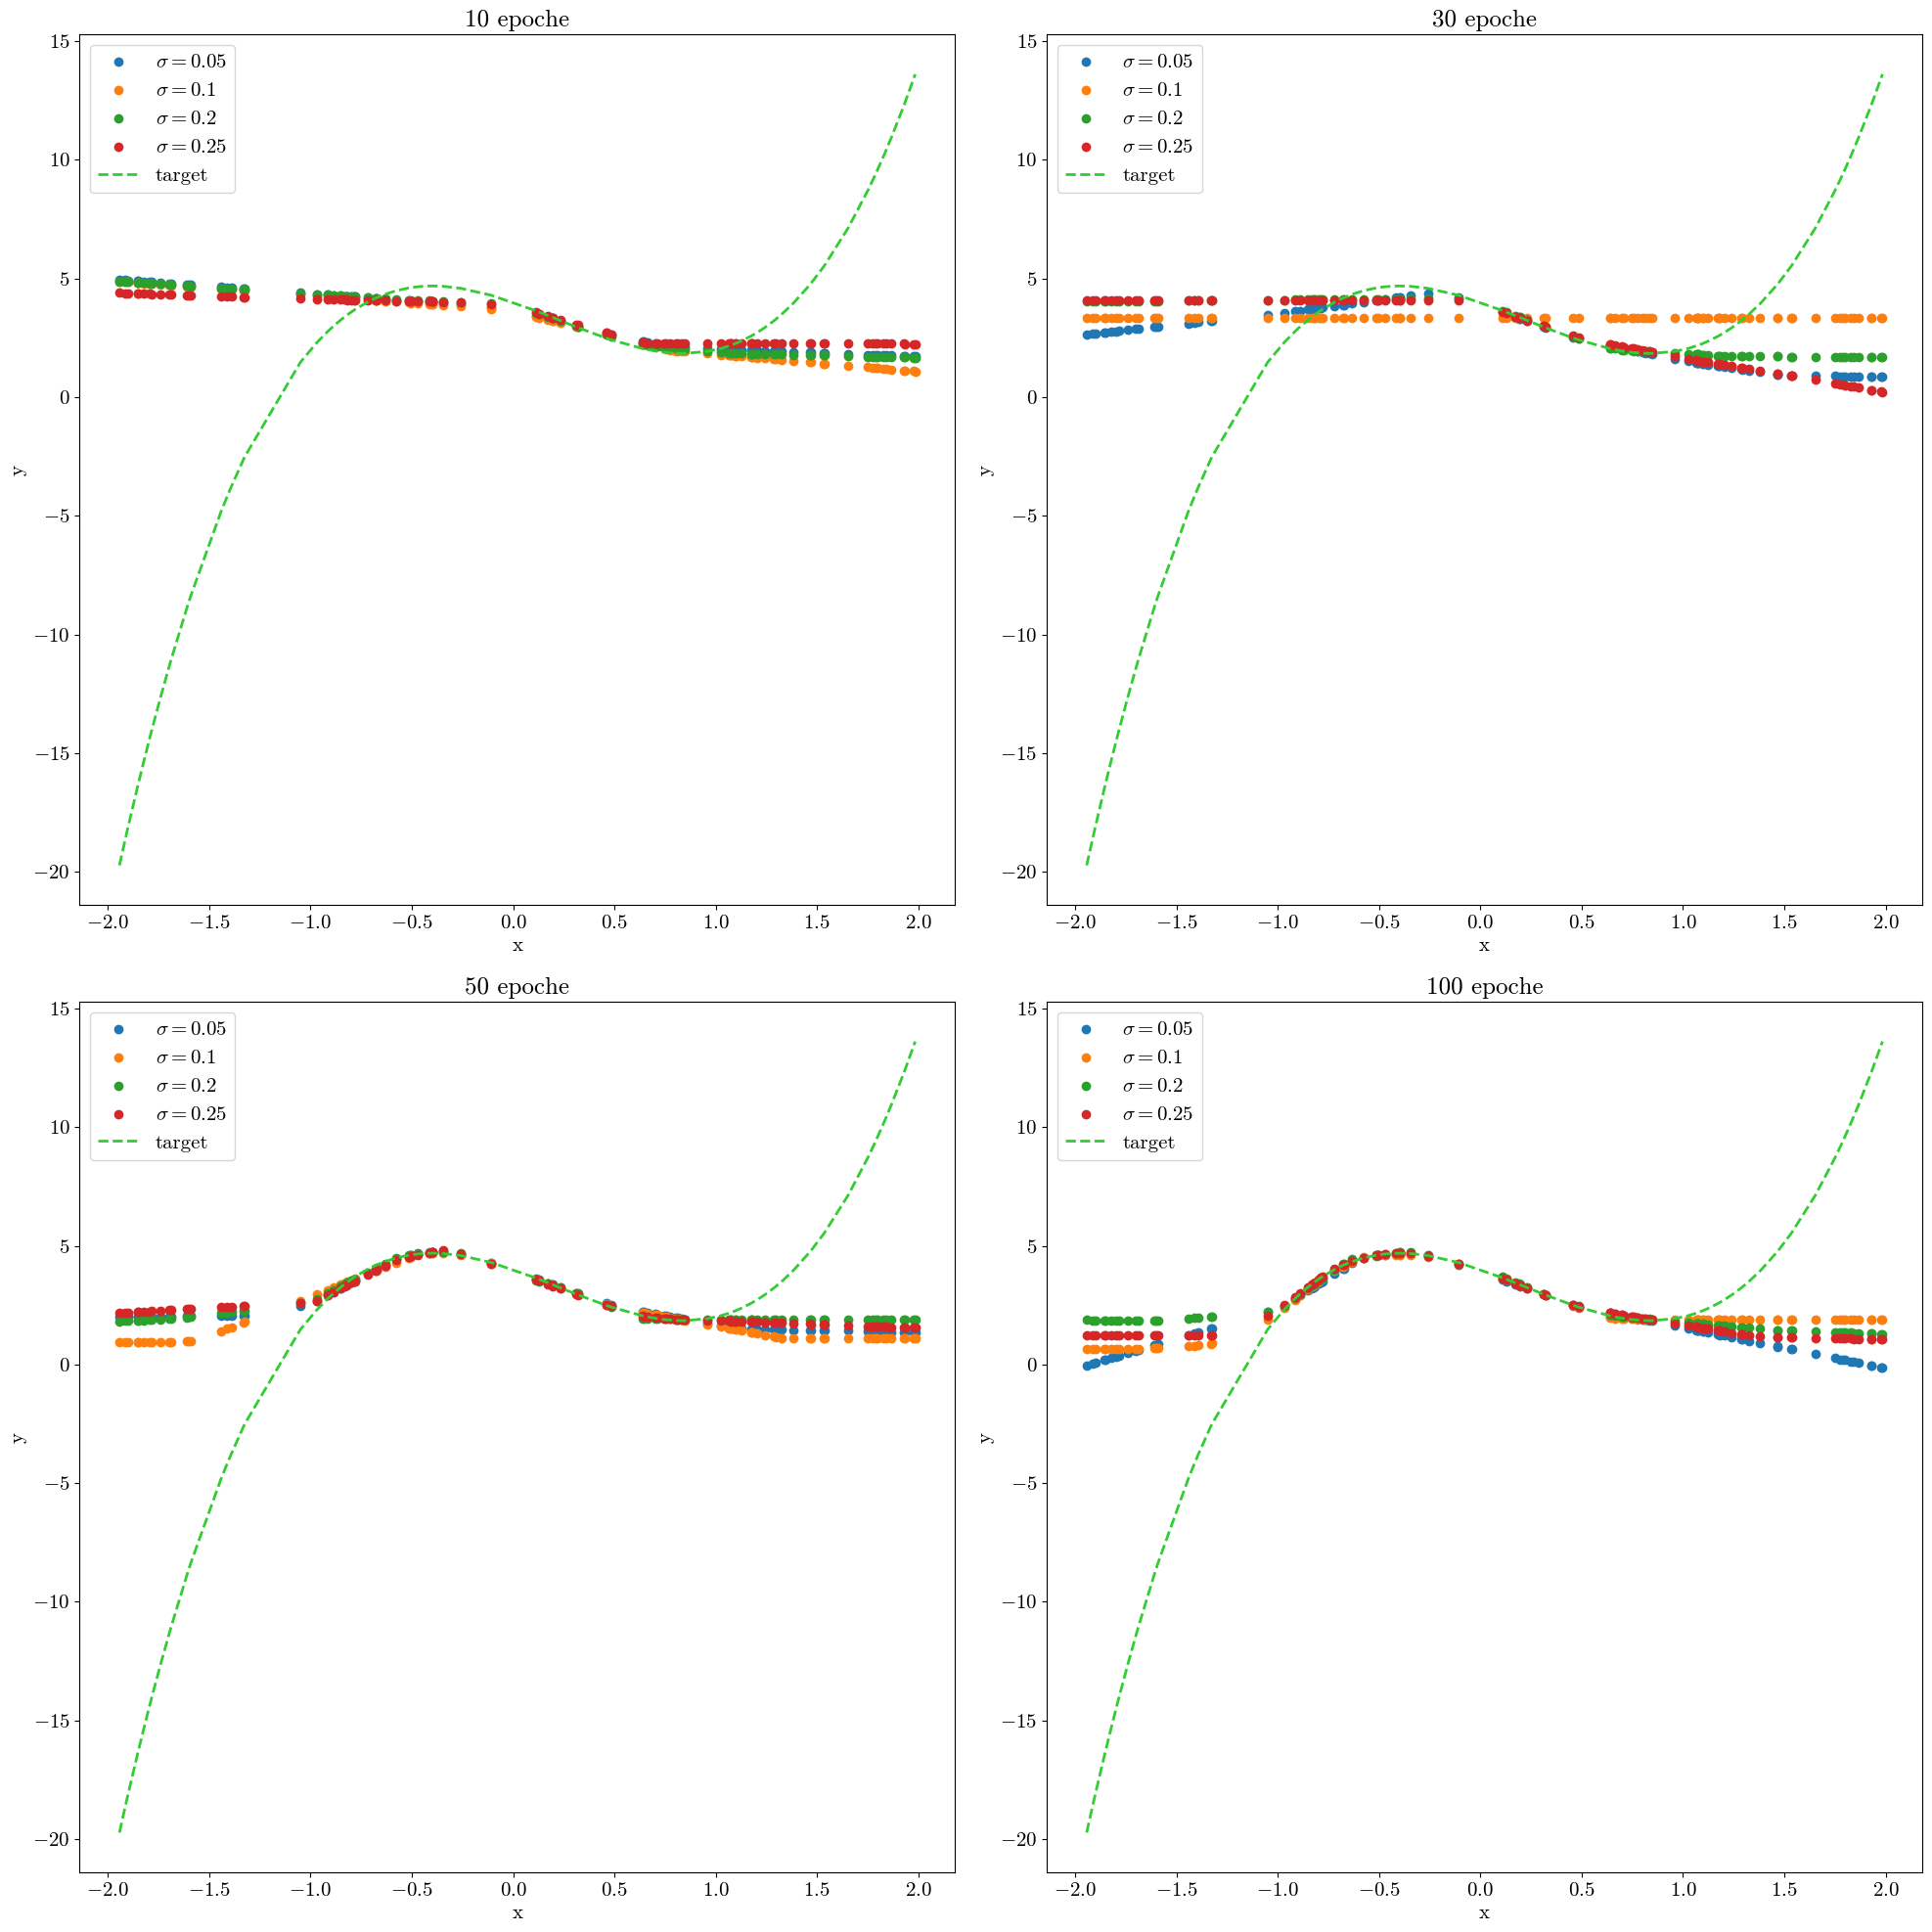

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
fig2, axes2 = plt.subplots(2, 2, figsize=(20, 20))
x_predicted_pol = np.empty((100,16))
y_predicted_pol = np.empty((100,16))
k = 0
t = 0
for i in range (4): #ciclo su vari valori di n_epochs
    if (i == 1):
        t = 0
        k = 1
    if (i == 2):
        t = 1
        k = 0
    if (i == 3):
        t = 1
        k = 1
    for j in range(4): #ciclo su vari valori di sigma
        x_valid_pol, y_target_pol, model_pol, loss_pol, val_loss_pol = training_validation(500,4,N_epochs[i],sigma[j], a,b,c,d)
        ax = axes[i,j]
        ax2 = axes2[t,k]
        ax.plot(loss_pol, label = f'train, sigma = {sigma[j]}')
        ax.plot(val_loss_pol, label = f'test, sigma = {sigma[j]}')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend()
        fig.tight_layout()
        
        x_predicted_pol[:,k] = np.random.uniform(-2, 2, 100)
        y_pred = model_pol.predict(x_predicted_pol[:,k])
        y_predicted_pol[:,k] = y_pred.ravel()
        
        ax2.scatter(x_predicted_pol[:,k], y_predicted_pol[:,k], label= f'$\sigma = {sigma[j]}$')
        x_predicted_pol[:,k].sort()
        if(j==3):
            ax2.plot(x_predicted_pol[:,k], d + c* x_predicted_pol[:,k] +b * x_predicted_pol[:,k]**2 + a * x_predicted_pol[:,k]**3, color ='limegreen', linewidth = 2, linestyle = '--',label = 'target')
        
        ax2.set_ylabel('y')
        ax2.set_xlabel('x')
        ax2.set_title(f'{N_epochs[i]} epoche')
        ax2.legend()
        fig2.tight_layout()
    


All'aumentare del numero di epoche otteniamo un fit sempre più preciso anche con $\sigma$ alte.

Cercando di far predire al modello anche punti fuori dal range di allenamento, che era $[-1,1]$, osserviamo che il modello non è in grado di predire risultati corretti.

### Exercise 11.3
  
Try to extend the model to fit a simple trigonometric 2D function such as $f(x,y) = \sin(x^2+y^2)$ in the range $x \in [-3/2,3/2]$ and $y \in [-3/2,3/2]$.

Ideas to meditate on these exercises and judge your results can be found <a href=https://xkcd.com/2048/>here</a>

#### Soluzione 11.3
Alleniamo un modello in grado di predirre punti che seguono la funzione f(x,y). Facciamo gli stessi passaggi di prima (con un valore fissato di $N_{epochs}$, $N_{train}$ e $\sigma$). Usiamo un modello con 5 layer con diverso numero di neuroni e con funzione di attivazione ``` relu```.

In [ ]:

# generate training inputs
np.random.seed(0)
x_train_3 = np.random.uniform(-3/2, 3/2, 150)
y_train_3 = np.random.uniform(-3/2, 3/2, 150)
x_valid_3 = np.random.uniform(-3/2, 3/2, 50)
y_valid_3 = np.random.uniform(-3/2, 3/2, 50)
x_valid_3.sort()
y_valid_3.sort()

X_valid_3, Y_valid_3 = np.meshgrid(x_valid_3, y_valid_3)
X_train_3, Y_train_3 = np.meshgrid(x_train_3, y_train_3)

print(X_valid_3.shape)
print(Y_valid_3.shape)

z_target_3 = np.sin(X_valid_3**2+Y_valid_3**2)  # ideal (target)  function

sigma = 0.1 # noise standard deviation, for the moment it is absent
z_train_3 = np.random.normal(np.sin(X_train_3**2+Y_train_3**2) , sigma) # actual measures from which we want to guess regression parameters
z_valid_3 = np.random.normal(np.sin(X_valid_3**2+Y_valid_3**2) , sigma)
print(z_valid_3.shape)

(50, 50)
(50, 50)
(50, 50)


<Figure size 600x600 with 0 Axes>

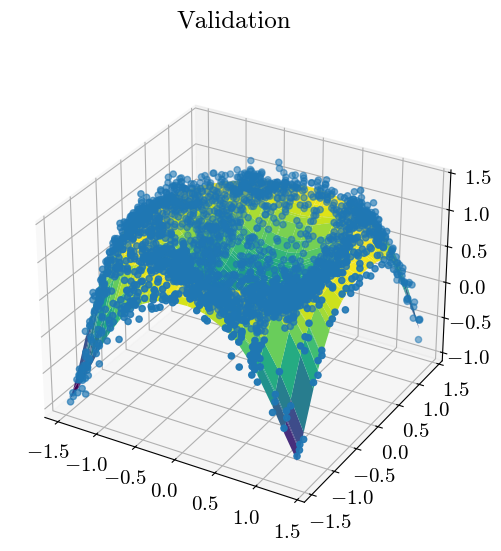

In [ ]:
# plot validation and target dataset
plt.figure()
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_valid_3, Y_valid_3, z_valid_3, label = 'validation')
ax.plot_surface(X_valid_3, Y_valid_3, np.sin(X_valid_3**2 + Y_valid_3**2), cmap='viridis', label = 'target')
fig.suptitle('Validation')
plt.grid(True)
plt.show()

In [ ]:
# compose the NN model
#import tensorflow as tf
#from tensorflow import keras
#
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense, Activation
#from tensorflow.keras import backend as K
#from tensorflow.keras.utils import get_custom_objects

model_sin = tf.keras.Sequential()
model_sin.add(Dense(4, input_shape=(2,), activation='relu'))
model_sin.add(Dense(16, activation='relu'))
model_sin.add(Dense(16, activation='relu'))
model_sin.add(Dense(4, activation='relu'))
model_sin.add(Dense(1))

# compile the model choosing optimizer, loss and metrics objects
model_sin.compile(optimizer='sgd', loss='mse', metrics=['mse'])

/home/catezac/.local/lib/python3.10/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# get a summary of our composed model
model_sin.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_38 (Dense)                │ (None, 4)              │            12 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 16)             │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 4)              │            68 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 1)              │             5 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 437 (1.71 KB)

 Trainable params: 437 (1.71 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model using training dataset
# over 10 epochs of 32 batch size each
# report training progress against validation data
#X_tr = np.stack((X_train_3, Y_train_3), axis = 1 ) # shape (N, 2)
X_val = np.column_stack((X_valid_3.ravel(), Y_valid_3.ravel()))  # shape (N_valid, 2)
X_train = np.column_stack((X_train_3.ravel(), Y_train_3.ravel())) 

Z_train = z_train_3.ravel()
Z_valid = z_valid_3.ravel()

history = model_sin.fit(x = X_train , y=Z_train,
          batch_size=32, epochs=50,
          shuffle=True, # a good idea is to shuffle input before at each epoch
          validation_data=(X_val, Z_valid))

Epoch 1/50


704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1856 - mse: 0.1856 - val_loss: 0.1317 - val_mse: 0.1317
Epoch 2/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1485 - mse: 0.1485 - val_loss: 0.1174 - val_mse: 0.1174
Epoch 3/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1277 - mse: 0.1277 - val_loss: 0.0936 - val_mse: 0.0936
Epoch 4/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0997 - mse: 0.0997 - val_loss: 0.0706 - val_mse: 0.0706
Epoch 5/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0751 - mse: 0.0751 - val_loss: 0.0542 - val_mse: 0.0542
Epoch 6/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0564 - mse: 0.0564 - val_loss: 0.0419 - val_mse: 0.0419
Epoch 7/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0423 - mse: 0.0423 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 8/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0318 - mse: 0.0318 - val_loss: 0.0239 - val_mse: 0.0239
Epoch 9/50
704/704 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0247 

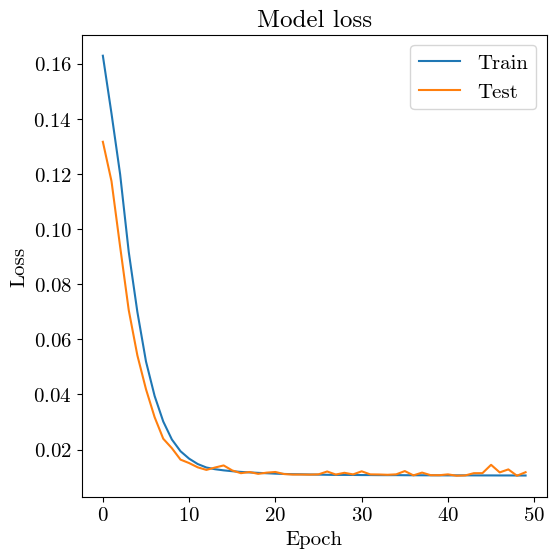

In [ ]:
# look into training history
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='best')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
(10000, 2)
(100, 100)
(100, 100)


/tmp/ipykernel_761/1962539181.py:27: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


<Figure size 600x600 with 0 Axes>

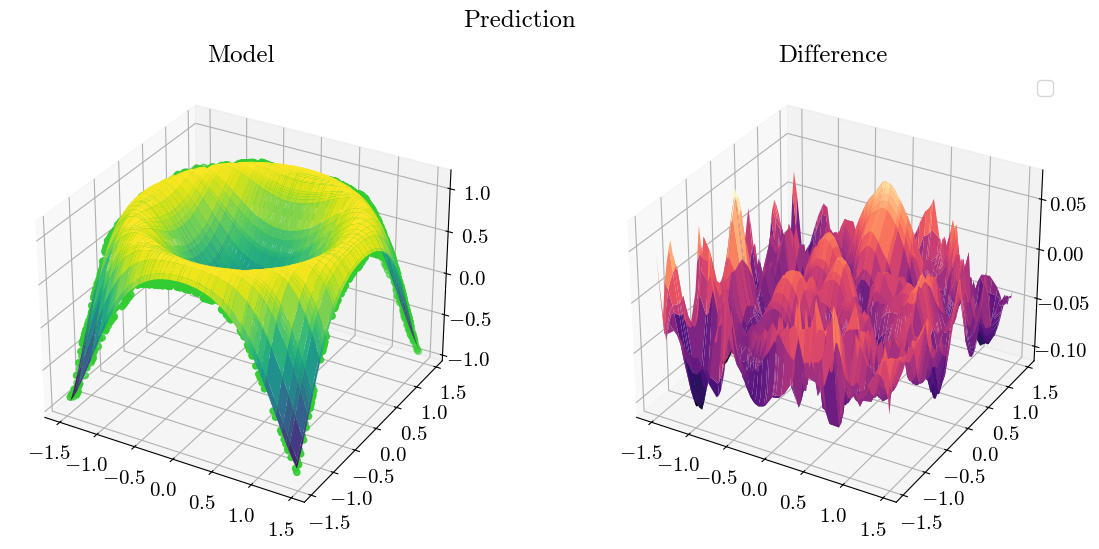

In [ ]:
x_predicted_3 = np.random.uniform(-3/2, 3/2, 100)
y_predicted_3 = np.random.uniform(-3/2,3/2, 100)

x_predicted_3.sort()
y_predicted_3.sort()

X_pred, Y_pred = np.meshgrid(x_predicted_3, y_predicted_3)

X_prediction = np.column_stack((X_pred.ravel(), Y_pred.ravel()))
Z_pred = model_sin.predict(X_prediction).reshape(X_pred.shape)

print(X_prediction.shape)
#print(X_pred)
print(Y_pred.shape)
print(Z_pred.shape)

# plot validation and target dataset
plt.figure()
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), subplot_kw={'projection': '3d'})
fig.suptitle('Prediction')
ax1.scatter(X_pred, Y_pred, Z_pred, color = 'limegreen', label = 'predicted')
Z = np.sin(X_pred**2+Y_pred**2)
ax1.plot_surface(X_pred, Y_pred, Z, cmap='viridis', label = 'target')
ax1.set_title('Model')
ax2.plot_surface(X_pred, Y_pred, Z_pred-Z, cmap ='magma')
ax2.set_title('Difference')
plt.legend()
plt.grid(True)
plt.show()

